# Init

## Imports

In [229]:
import sys, os

import tensorflow as tf

import numpy as np

import requests

import matplotlib

# Specify the backend of matplotlib to display graphs (here tkinter backend)
matplotlib.use("TkAgg")

from matplotlib import pyplot as plt

# Used to display matplotlib inside jupyter notebook
%matplotlib inline


# Disable tensorflow update warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Declare Global Consts

In [230]:
API_KEY  = 'A0P959H21M0HZXUB'
LOOKBACK = 24
PREDICT  = 100
STOCK = 'DAX'

# Create dataset

## Fetch data

In [231]:
def fetch_data(stock):
    r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&outputsize=full&apikey={API_KEY}&datatype=csv')
    return r.text.split('\r\n')

dataset = fetch_data(STOCK)
print(dataset)

['timestamp,open,high,low,close,volume', '2019-08-20,24.5755,24.5755,24.5463,24.5600,1425', '2019-08-19,24.7600,24.8160,24.6890,24.7800,2700', '2019-08-16,24.2110,24.3700,24.2110,24.3700,1400', '2019-08-15,24.0900,24.0889,24.0470,24.0800,2400', '2019-08-14,24.5000,24.5000,24.1500,24.1500,3900', '2019-08-13,24.7100,25.0590,24.7100,25.0100,1700', '2019-08-12,24.9420,24.9420,24.8920,24.8920,700', '2019-08-09,24.9000,25.1484,24.9000,25.1500,2500', '2019-08-08,25.0400,25.3050,25.0400,25.0700,2900', '2019-08-07,24.6900,24.9940,24.6800,24.8960,5500', '2019-08-06,24.8600,24.9800,24.6230,24.6700,3200', '2019-08-05,24.8216,24.8850,24.6400,24.6400,4900', '2019-08-02,25.4000,25.6900,25.4000,25.5280,100', '2019-08-01,25.4000,25.6900,25.4000,25.5280,1300', '2019-07-31,25.8200,25.8820,25.2700,25.2700,3500', '2019-07-30,25.7200,25.8290,25.6450,25.8290,2800', '2019-07-29,26.3400,26.4100,26.3200,26.4100,3300', '2019-07-26,26.2100,26.3170,26.1300,26.1300,8400', '2019-07-25,26.5700,26.6000,26.1600,26.2200

In [232]:
def format_data(dataset):
    tab = []
    for line in dataset:
        tab.append(line.split(','))
    for line in tab[1:]:
        for i in range(len(line)):
            if i == 0:
                line[i] = len(tab) - tab.index(line) - 1
            line[i] = float(line[i])    
    labels = tab[0]
    tab = list(reversed(tab[1:]))
    tab = tab[1:] # Remove last line which is empty
    return labels, tab    

labels, dataset = format_data(dataset)

## Visualize dataset

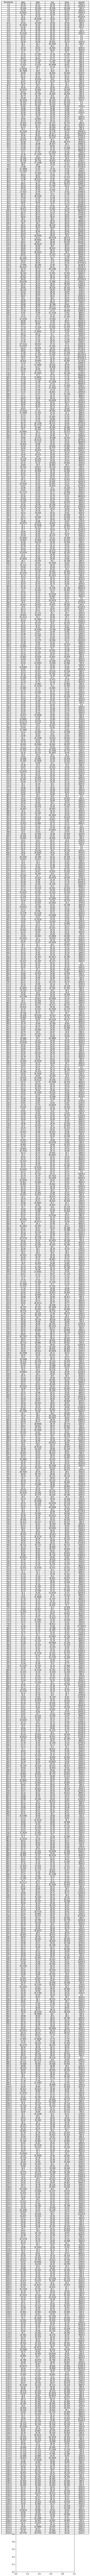

In [233]:
def visualize_data(labels, dataset):
    plt.table(cellText=dataset,
          colWidths = [0.25]*len(dataset[0]),
          colLabels=labels,
          cellLoc = 'center', rowLoc = 'center',
          loc='top')

visualize_data(labels, dataset)

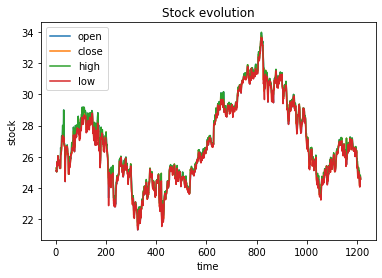

In [234]:
def plot_data(dataset):
    data_open = [data[1] for data in dataset]
    data_high = [data[2] for data in dataset]
    data_low = [data[3] for data in dataset]
    data_close = [data[4] for data in dataset]
    data_time = [data[0] for data in dataset]
    plt.plot(data_time , data_open)
    plt.plot(data_time , data_close)
    plt.plot(data_time , data_high)
    plt.plot(data_time , data_low)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['open', 'close', 'high', 'low'], loc='upper left')
    plt.show()

plot_data(dataset)

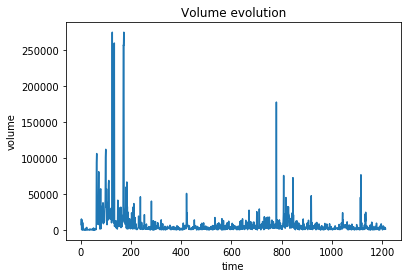

In [235]:
def plot_volumes(dataset):
    data_volume = np.array([data[5] for data in dataset])
    data_time = [data[0] for data in dataset]
    plt.plot(data_time , data_volume)
    plt.title('Volume evolution')
    plt.ylabel('volume')
    plt.xlabel('time')
    plt.show()

plot_volumes(dataset)

## Normalize data

In [236]:
def normalize_data(dataset):
    dataset = np.swapaxes(dataset,0,1)[1:]
    for i in range(len(dataset)):
        dataset[i] = (dataset[i] - min(dataset[i])) / (max(dataset[i]) - min(dataset[i]))
    dataset = np.swapaxes(dataset, 0, 1)
    return dataset

dataset = normalize_data(dataset)
print(dataset)

[[0.29992107 0.30017796 0.30694669 0.30696279 0.02693848]
 [0.3038674  0.29376493 0.31098546 0.30209938 0.05533309]
 [0.29502762 0.28077854 0.30193861 0.28896814 0.0010921 ]
 ...
 [0.23054459 0.22803136 0.23594507 0.23563265 0.00509647]
 [0.2738753  0.26378401 0.27455574 0.26886601 0.0098289 ]
 [0.25931334 0.24450483 0.26302908 0.25103348 0.00518748]]


## Split dataset

In [237]:
def split_dataset(dataset):
    x, y = [], []
    for i in range(LOOKBACK, len(dataset)):
        x.append(dataset[i-LOOKBACK:i])
        y.append(dataset[i])
    return np.array(x), np.array(y)

x_train, y_train = split_dataset(dataset)

x_test = x_train[int(len(x_train) - PREDICT):]
x_train = x_train[:int(len(x_train) - PREDICT)]

y_test = y_train[int(len(y_train) - PREDICT):]
y_train = y_train[:int(len(y_train) - PREDICT)]

print("Train\t", x_train.shape, '\t', y_train.shape)
print("Test\t", x_test.shape, '\t', y_test.shape)

Train	 (1090, 24, 5) 	 (1090, 5)
Test	 (100, 24, 5) 	 (100, 5)


# AI

## Define model

In [238]:
def define_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(len(x_train), input_shape=(LOOKBACK, 5), return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(5, activation='relu'))
    return model

model = define_model()

## Compile model

In [239]:
def compile_model(model):
    model.compile(optimizer='adam',loss='mse')
    model.summary()
    return model

model = compile_model(model)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1090)              4778560   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1090)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 5455      
Total params: 4,784,015
Trainable params: 4,784,015
Non-trainable params: 0
_________________________________________________________________


## Train AI

In [240]:
def train_ai(model, x_train, y_train):
    history = model.fit(x_train, y_train, epochs=200, batch_size=27, validation_split=0.2)
    return history, model
    
history, model = train_ai(model, x_train, y_train)

Train on 872 samples, validate on 218 samples
Epoch 1/200
872/872 [==============================] - 17s 19ms/sample - loss: 0.0399 - val_loss: 0.0019
Epoch 2/200
872/872 [==============================] - 15s 17ms/sample - loss: 0.0035 - val_loss: 0.0016
Epoch 3/200
872/872 [==============================] - 15s 17ms/sample - loss: 0.0031 - val_loss: 0.0015
Epoch 4/200
872/872 [==============================] - 15s 17ms/sample - loss: 0.0034 - val_loss: 0.0011
Epoch 5/200
872/872 [==============================] - 17s 20ms/sample - loss: 0.0030 - val_loss: 0.0014
Epoch 6/200
621/872 [====================>.........] - ETA: 4s - loss: 0.0035

KeyboardInterrupt: 

## Visualize training

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_loss(history)

## Test model

In [ ]:
def test_model(model, x_test, y_test):
    output = model.predict(np.array([x_test]))
    error = []
    for i in range(len(output)):
        error.append(abs(100 - output[i] * 100 / y_test[i]))
    error = np.array(error)
    return np.mean(error)

errors_means = []
for i in range(PREDICT):
    errors_means.append(test_model(model, x_test[i], y_test[i]))
for mean in errors_means:
    print('#' + str(errors_means.index(mean)), "\tAverage error", int(mean), "%")
print("\nAVERAGE ERROR", np.mean(np.array(errors_means)), "% (calculated on the", PREDICT, "last time units of the dataset)")

## Visualize accuracy

In [ ]:
def plot_result(y_train, x_test, y_test):
    # Dataset
    data_open = [data[1] for data in y_train]
    data_high = [data[2] for data in y_train]
    data_low = [data[3] for data in y_train]
    data_close = [data[4] for data in y_train]
    data_time = [i for i in range(len(y_train))]
    plt.plot(data_time , data_open)
    #plt.plot(data_time , data_close)
    #plt.plot(data_time , data_high)
    #plt.plot(data_time , data_low)
    
    # Prediction
    data_time = [data_time[-1] + i for i in range(len(y_test))]
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)
    #plt.plot(data_time , data_close)
    #plt.plot(data_time , data_high)
    #plt.plot(data_time , data_low)

    # Expected
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = y_test[i]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)
    #plt.plot(data_time , data_close)
    #plt.plot(data_time , data_high)
    #plt.plot(data_time , data_low)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['data', 'got', "expected"], loc='upper left')
    plt.show()
    
     # Prediction
    data_time = [i for i in range(len(y_test))]
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)
    #plt.plot(data_time , data_close)
    #plt.plot(data_time , data_high)
    #plt.plot(data_time , data_low)

    # Expected
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = y_test[i]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)
    #plt.plot(data_time , data_close)
    #plt.plot(data_time , data_high)
    #plt.plot(data_time , data_low)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['got', "expected"], loc='upper left')
    plt.show()

plot_result(y_train, x_test, y_test)

In [ ]:
def plot_volumes_result(y_train, x_test, y_test):
    # Dataset
    data_volume = [data[4] for data in y_train]
    data_time = [i for i in range(len(y_train))]
    plt.plot(data_time , data_volume)
    
    # Prediction
    data_time = [data_time[-1] + i for i in range(len(y_test))]
    data_volume = []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)

    # Expected
    data_volume = []
    for i in range(PREDICT):
        tab = y_test[i]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)
    plt.title('Volume evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['data', 'got', "expected"], loc='upper left')
    plt.show()
    
    # Prediction
    data_time = [i for i in range(len(y_test))]
    data_volume = []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)

    # Expected
    data_volume = []
    for i in range(PREDICT):
        tab = y_test[i]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)
    plt.title('Volume evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['got', "expected"], loc='upper left')
    plt.show()

plot_volumes_result(y_train, x_test, y_test)